# Optimality Condition Decomposition

Consider the following optimization problem.

\begin{equation*}
\begin{aligned}
\min_{x,y} z = \sum_{i=1}^{n}(x_{i}c_{i} - c_{i})^2 + \sum_{i=1}^{n}(y_{i}d_{i} - d_{i})^2
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
s.t. && \sum_{i=1}^{n} x_ie_{1i} \geq  b_1 \\
&& \sum_{i=1}^{n} y_if_{2i} \geq  b_2 \\
&& \sum_{i=1}^{n} x_ie_{3i} + y_if_{3i} - 5b_3 = 0: && \lambda_{x} \\
&& \sum_{i=1}^{n} [x_ie_{4i} + y_if_{4i}] - 5b_4 = 0: && \lambda_{y}\\
&& x_i,y_i  \geq  0 && \forall i \in n
\end{aligned}
\end{equation*}

**Subproblem 1**

\begin{equation*}
\begin{aligned}
\min_{x,y} z = \sum_{i=1}^{n}(x_{i}c_{i} - c_{i})^2 + \bar{\lambda_{y}}(\sum_{i=1}^{n} [x_ie_{4i} + \bar{y_i}f_{4i}] - 5b_4)
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
s.t. && \sum_{i=1}^{n} x_ie_{1i} \geq  b_1 \\
&& \sum_{i=1}^{n} [x_ie_{3i} + \bar{y_i}f_{3i}] - 5b_3 = 0:  && \lambda_{x} \\
&& x_i,\bar{y_i}  \geq  0 && \forall i \in n
\end{aligned}
\end{equation*}

**Subproblem 2**

\begin{equation*}
\begin{aligned}
\min_{x,y} z = \sum_{i=1}^{n}(y_{i}d_{i} - d_{i})^2 + \bar{\lambda_{x}}(\sum_{i=1}^{n} [\bar{x_i}e_{3i} + y_if_{3i}] - 5b_3)
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
s.t. && \sum_{i=1}^{n} y_if_{2i} \geq  b_2 \\
&& \sum_{i=1}^{n} [\bar{x_i}e_{4i} + y_if_{4i}] - 5b_4 = 0:  && \lambda_{y} \\
&& \bar{x_i},y_i  \geq  0 && \forall i \in n
\end{aligned}
\end{equation*}


## High Interconnection

Below is the data set used to find an optimal solution. There are 6 variables (n = 6) and 4 constraints.

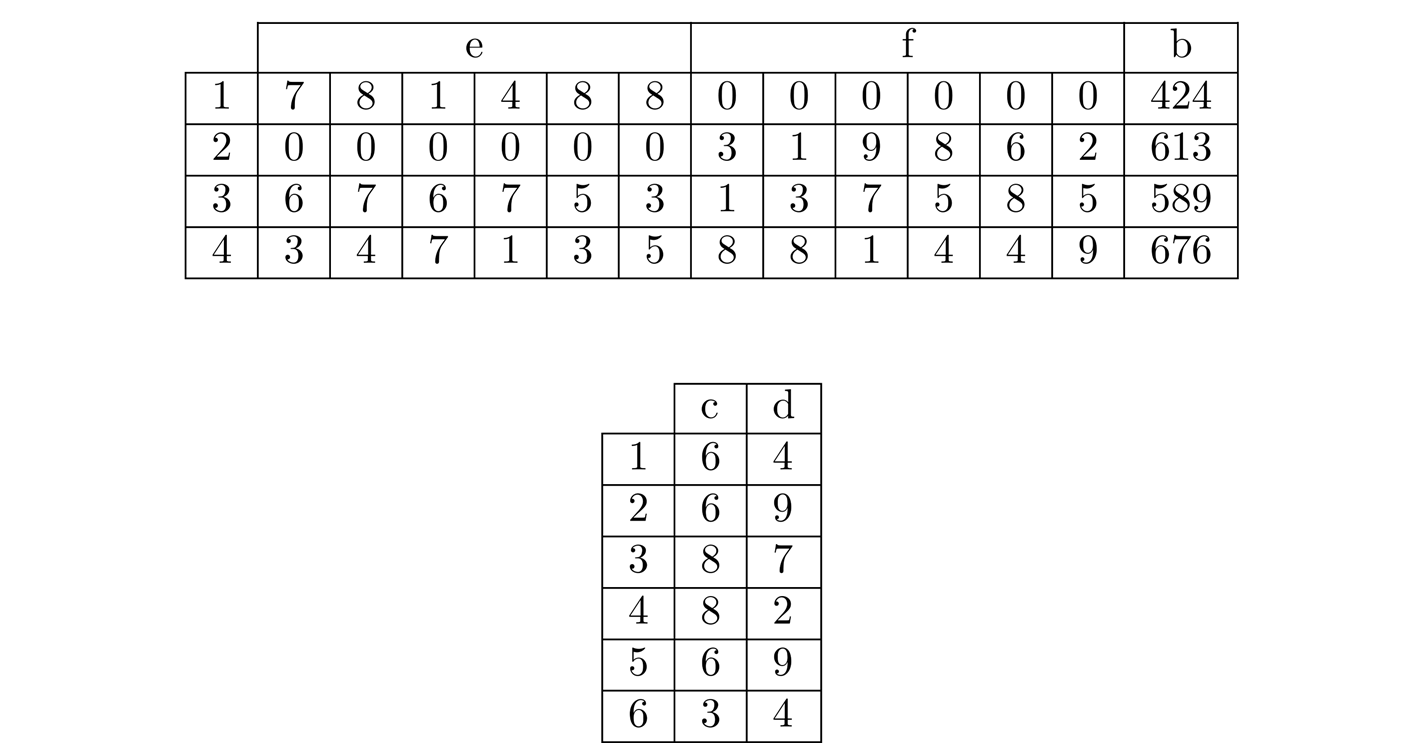

**Initialization**

\begin{equation*}
\begin{aligned}
{\lambda_x}^0, {\lambda_y}^0 = 2\\
{x_i}^{0}, {y_i}^{0} = 5 && \forall i \in n \\
\end{aligned}
\end{equation*}


### Intialization

In [26]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (10,10)

random.seed(10)

epsilon = 4

#number of x or y variables
num_var = 6

#number of constraints
num_cons = 4

solver = 'gurobi'

e = [] # x coefficients in constraint funcs
f = [] # y coefficients in constraint funcs
b = [] # column vector of constraints
c = [] # x coefficients in obj func
d = [] # y coefficients in obj func
obj_val_x = [] # stores obj func values
obj_val_y = []
#creating random constraint coefficients and random b
for i in list(range(0,num_cons)):
    e.append([])
    f.append([])
    b.append(random.randrange(400,800,3))
    for j in list(range(0,num_var)):
        if i == 0:
            e[i].append(random.randrange(1,10,1))
            f[i].append(0)
        elif i == 1:
            e[i].append(0)
            f[i].append(random.randrange(1,10,1))
        else:
            e[i].append(random.randrange(1,10,1))
            f[i].append(random.randrange(1,10,1))

for i in list(range(0,num_var)):
        c.append(random.randrange(1,10,1))
        d.append(random.randrange(1,10,1))

#creating variables to store x and y variables and x and y lambda
x_vars_list = [[]]
y_vars_list = [[]]
vx_vars_list = [[]]
vy_vars_list = [[]]
x_lams = [2]
y_lams = [2]

for j in list(range(0,num_var)):
    #initializing variables
    x_vars_list[0].append(5)
    y_vars_list[0].append(5)

iteration = 1

### Solving X Function

In [27]:
def solve_x(y_vars_list,y_lams):
    model = ConcreteModel()

    model.dual = Suffix(direction = Suffix.IMPORT)

    model.I = RangeSet(1,num_var)
    model.J = RangeSet(1,num_cons)

    model.x = Var(model.I, domain = NonNegativeReals)
    model.y = Var(model.I, domain = NonNegativeReals)

    #fixing the y values to the last row of stored y values
    for i in list(range(0,len(y_vars_list[0]))):
          model.y[i+1].value = y_vars_list[iteration-1][i]
          model.y[i+1].fixed = True

    def obj_rule(model):
          return sum((model.x[i]*c[i-1] - c[i-1])**2 for i in model.I) + y_lams[iteration-1]*(sum(model.x[i]*e[-1][i-1] + \
                                                                     model.y[i]*f[-1][i-1] for i in model.I) - 5*b[-1])
    model.obj = Objective(rule = obj_rule)

    def cons_rule(model,j): 
          if   j == 1:
               return sum(model.x[i] * e[j-1][i-1] for i in model.I) >= b[j-1]
          elif j == 3:
               return sum(model.x[i] * e[j-1][i-1] + model.y[i]*f[j-1][i-1] for i in model.I) - 5*b[j-1] == 0
          else:  
               return Constraint.Skip
          
    model.cons = Constraint(model.J, rule = cons_rule)

    opt = SolverFactory(solver)
    result_obj = opt.solve(model)

    #model.pprint()

    x_lams.append(value(model.dual[model.cons[3]]))

    x_vars_list.append([])
    for i in list(range(1,num_var+1)):
         x_vars_list[iteration].append(value(model.x[i]))

    obj_val_x.append(value(model.obj))
    log_infeasible_constraints(model)

### Solving Y Function

In [28]:
def solve_y(x_vars_list,x_lams):
    model = ConcreteModel()

    model.dual = Suffix(direction = Suffix.IMPORT)

    model.I = RangeSet(1,num_var)
    model.J = RangeSet(1,num_cons)

    model.x = Var(model.I, domain = NonNegativeReals)
    model.y = Var(model.I, domain = NonNegativeReals)

    #fixing x variables
    for i in list(range(0,len(x_vars_list[0]))):
          model.x[i+1].value = x_vars_list[iteration-1][i]
          model.x[i+1].fixed = True

    def obj_rule(model):
          return sum((model.y[i]*d[i-1] - d[i-1])**2 for i in model.I) + x_lams[iteration-1]*(sum(model.x[i]*e[-2][i-1] \
                                                                     + model.y[i]*f[-2][i-1] for i in model.I) - 5*b[-2])
    
    model.obj = Objective(rule = obj_rule)

    def cons_rule(model,j): 
          if   j == 2:
               return sum(model.y[i]*f[j-1][i-1] for i in model.I) >= b[j-1]
          elif j == 4:
               return sum(model.x[i] * e[j-1][i-1] + model.y[i]*f[j-1][i-1] for i in model.I) - 5*b[j-1] == 0
          else:  
               return Constraint.Skip

    model.cons = Constraint(model.J, rule = cons_rule)

    opt = SolverFactory(solver)
    result_obj = opt.solve(model)

    #model.pprint()

    y_lams.append(value(model.dual[model.cons[4]]))

    y_vars_list.append([])
    for i in list(range(1,num_var+1)):
         y_vars_list[iteration].append(value(model.y[i]))
    
    obj_val_y.append(value(model.obj))
    log_infeasible_constraints(model)

### Iterative Function

In [29]:
max_iterations = 800

#iterating through functions
convergence = False
check = [[]]

while convergence == False:

    solve_x(y_vars_list,y_lams)
             
    solve_y(x_vars_list,x_lams)     
    iteration += 1
    if all(np.around(x_vars_list[-1],epsilon) == np.around(x_vars_list[-2],epsilon)) and \
           all(np.around(y_vars_list[-1],epsilon) == np.around(y_vars_list[-2],epsilon)) and \
            np.around(x_lams[-1],epsilon) == np.around(x_lams[-2],epsilon) and \
                np.around(y_lams[-1],epsilon) == np.around(y_lams[-2],epsilon):
        convergence = True

### Output

In [30]:
total_obj_val = [0]

for i in list(range(0,len(obj_val_x))):
    total_obj_val.append(obj_val_x[i] + obj_val_y[i])

#Creating legend
x = []
y = []
for i in list(range(1,num_var+1)):
     x.append("x"+str(i)+"")
     y.append("y"+str(i)+"")

x_dat = pd.DataFrame(x_vars_list, columns=x)
y_dat = pd.DataFrame(y_vars_list, columns=y)
xlams_dat = pd.DataFrame(x_lams, columns = ['\u03BBx'])
ylams_dat = pd.DataFrame(y_lams, columns = ['\u03BBy'])
obj_val_dat = pd.DataFrame(total_obj_val, columns = ['Obj'])
pd.concat([x_dat,y_dat,xlams_dat,ylams_dat, obj_val_dat], axis= 1)

,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,λx,λy,Obj
0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00,5.000000,5.000000,5.000000e+00,5.000000e+00,5.000000e+00,5.000000,2.000000,2.000000,0.000000e+00
1,86.673573,100.938613,49.128885,57.262345,72.380755,1.719583e+02,116.076704,23.706509,5.556702e+00,2.300284e+02,1.227301e+01,130.219104,1029.082876,460.556814,2.159601e+06
2,33.326436,35.515864,4.791220,31.209474,24.740386,1.282954e-12,129.835553,8.482172,6.795595e-15,2.612392e+01,5.372807e-15,3.009919,618.195643,484.141297,7.159663e+05
3,92.554309,104.451268,37.369883,70.538400,73.933165,8.997003e+01,184.926218,29.699060,1.499187e-14,2.111739e+01,1.294017e-13,133.057366,1340.722356,812.979326,1.350329e+06
4,76.208309,83.097338,17.899070,66.233956,58.027901,4.415855e-12,177.244365,13.102920,3.764434e-13,4.648795e+00,2.452157e-13,15.486811,1308.989377,685.498650,1.831779e+06
5,96.522583,107.682606,33.309620,77.075340,75.841745,5.875376e+01,203.192410,24.778879,7.826960e-14,3.476313e-13,2.150244e-13,69.956029,1489.020315,972.393312,1.535534e+06
6,92.897775,101.461339,22.305207,80.299972,70.828748,3.894910e-11,182.323703,18.434061,1.657480e-16,3.963622e-16,1.959646e-16,24.678112,1588.969955,911.422350,2.100517e+06
7,100.184984,110.386493,28.309605,83.891364,77.324832,2.214896e+01,209.584188,22.584902,1.660046e-14,4.698528e-14,9.502217e-14,43.242881,1645.930984,1032.957997,1.867562e+06
8,98.291967,107.333976,23.446794,85.022814,74.903320,1.615360e-11,201.174598,20.220526,1.629357e-13,5.031226e-13,2.624073e-13,26.884468,1683.982606,1006.439766,2.235164e+06
9,101.204360,110.915922,25.913710,86.416138,77.514469,5.712100e+00,212.036434,21.896301,1.334862e-14,4.568702e-14,6.169881e-14,34.496220,1705.672207,1054.643564,2.115802e+06


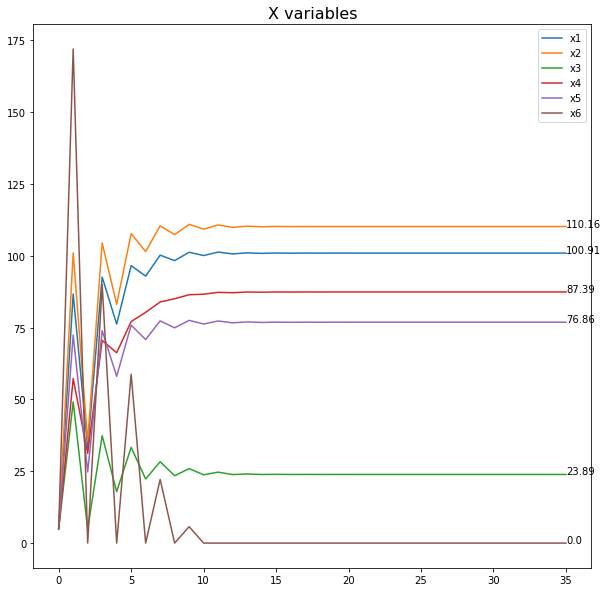

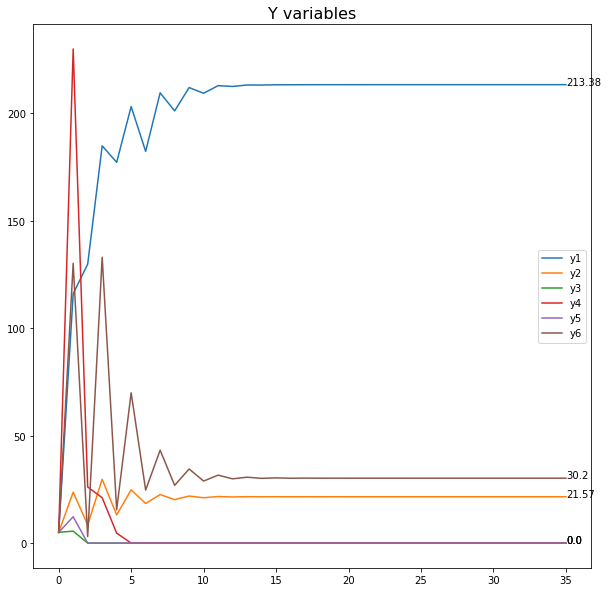

In [31]:
plt.plot(x_vars_list, label = x);  # ; suppress the matplotlib text
plt.title("X variables",fontsize = 16)
if num_var <=20 :
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
#plt.xticks(range(0,iteration));
plt.show()

plt.plot(y_vars_list, label = y);  # ; suppress the matplotlib text
plt.title("Y variables",fontsize = 16)
if num_var <= 20:
    for i in [iteration-1]:
        for j in list(range(0,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(1,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
#plt.xticks(range(0,iteration));
plt.show()

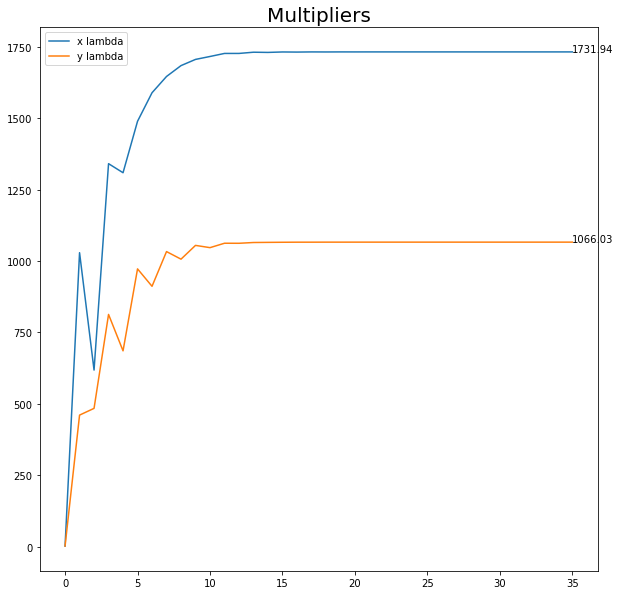

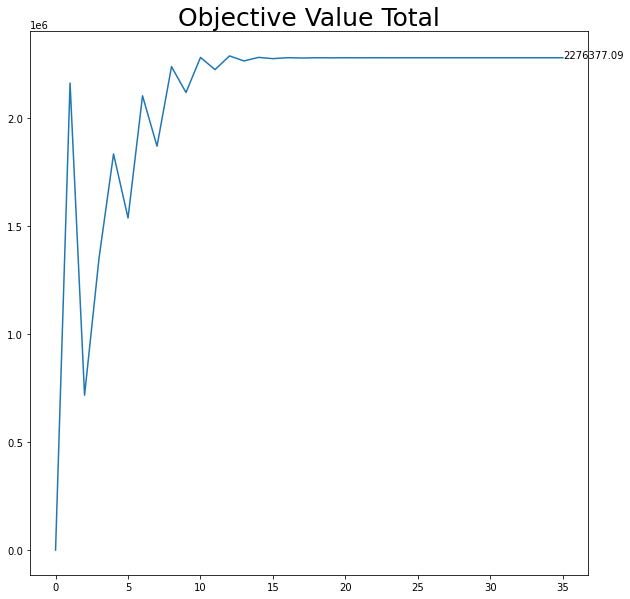

In [32]:
plt.plot(x_lams, label = "x lambda"); #suppress matpolotlib output
for i in [iteration-1]:
    plt.text(list(range(0,len(x_lams)))[i],x_lams[i],str(round(x_lams[i],2)))
    
plt.plot(y_lams, label = "y lambda");  # ; suppress the matplotlib text

for i in [iteration-1]:
    plt.text(list(range(0,len(y_lams)))[i],y_lams[i],str(round(y_lams[i],2)))

plt.title("Multipliers", fontsize = 20)
plt.legend();
#plt.xticks(range(0,iteration));
plt.show()

plt.plot(total_obj_val);
for i in [len(total_obj_val)-1]:
    plt.text(i,total_obj_val[i],str(round(total_obj_val[i],2)));
plt.title('Objective Value Total',fontsize = 25)
#plt.xticks(range(0,iteration));
plt.show()

# Low interconnection

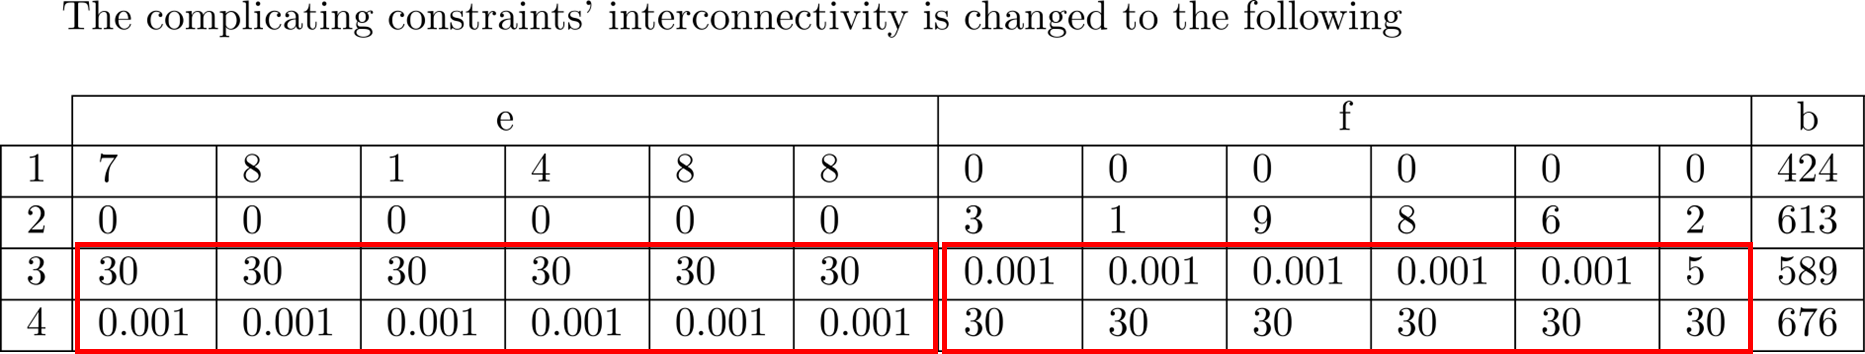

In [33]:
obj_val_x = [] # stores obj func values
obj_val_y = [] # stores obj func values

for i in  [-2,-1]:
    for j in list(range(0,num_var)):
        if i == -2:
            e[i][j] = 30
            f[i][j] = 0.001
        if i == -1:
            e[i][j] = 0.001
            f[i][j] = 30

#creating variables to store x and y variables and x and y lambda
x_vars_list = [[]]
y_vars_list = [[]]
vx_vars_list = [[]]
vy_vars_list = [[]]
x_lams = [2]
y_lams = [2]

for j in list(range(0,num_var)):
    #initializing variables
    x_vars_list[0].append(5)
    y_vars_list[0].append(5)

iteration = 1

In [34]:
max_iterations = 1000

#iterating through functions
convergence = False
check = [[]]

while convergence == False and iteration <= max_iterations:
    #print ('-'*500)  
    #print(("This is iteration  " + str(iteration) + " ")*100)
    #print(("This is iteration  " + str(iteration) + " ")*100)
    #print ('-'*500)  
    solve_x(y_vars_list,y_lams)
    #print ('-'*500)                 
    #print ('-'*500)              
    solve_y(x_vars_list,x_lams)     
    iteration += 1
    if all(np.around(x_vars_list[-1],epsilon) == np.around(x_vars_list[-2],epsilon)) and \
           all(np.around(y_vars_list[-1],epsilon) == np.around(y_vars_list[-2],epsilon)) and \
            np.around(x_lams[-1],epsilon) == np.around(x_lams[-2],epsilon) and \
                np.around(y_lams[-1],epsilon) == np.around(y_lams[-2],epsilon):
        convergence = True

### Output

In [35]:
total_obj_val = [0]

for i in list(range(0,len(obj_val_x))):
    total_obj_val.append(obj_val_x[i] + obj_val_y[i])

#Creating legend
x = []
y = []
for i in list(range(1,num_var+1)):
     x.append("x"+str(i)+"")
     y.append("y"+str(i)+"")

x_dat = pd.DataFrame(x_vars_list, columns=x)
y_dat = pd.DataFrame(y_vars_list, columns=y)
xlams_dat = pd.DataFrame(x_lams, columns = ['\u03BBx'])
ylams_dat = pd.DataFrame(y_lams, columns = ['\u03BBy'])
obj_val_dat = pd.DataFrame(total_obj_val, columns = ['Obj'])
pd.concat([x_dat,y_dat,xlams_dat,ylams_dat, obj_val_dat], axis= 1)

,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,λx,λy,Obj
0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,2.000000,0.000000
1,12.343467,12.343467,7.380700,7.380700,12.343467,46.373867,16.869107,4.134638,6.181749,64.476427,4.134638,16.869107,27.224387,16.927114,55670.657384
2,12.343128,12.343128,7.380509,7.380509,12.343128,46.372510,16.868769,4.134572,6.181639,64.475075,4.134572,16.868769,27.224070,16.927594,64720.235669
3,12.343128,12.343128,7.380509,7.380509,12.343128,46.372510,16.868769,4.134572,6.181639,64.475075,4.134572,16.868769,27.224070,16.927594,64716.831407


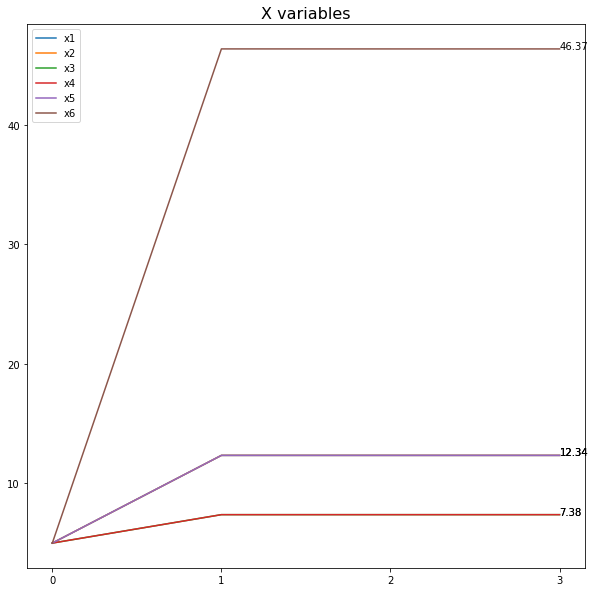

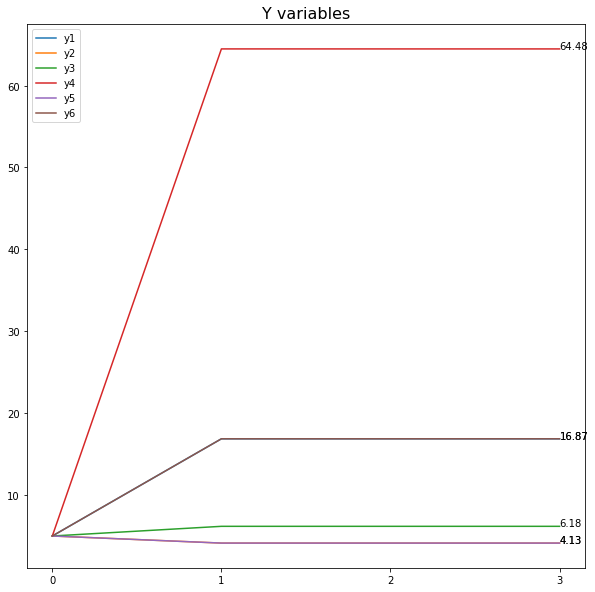

In [36]:
plt.plot(x_vars_list, label = x);  # ; suppress the matplotlib text
plt.title("X variables",fontsize = 16)
if num_var <=20 :
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
plt.xticks(range(0,iteration));
plt.show()

plt.plot(y_vars_list, label = y);  # ; suppress the matplotlib text
plt.title("Y variables",fontsize = 16)
if num_var <= 20:
    for i in [iteration-1]:
        for j in list(range(0,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(1,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
plt.xticks(range(0,iteration));
plt.show()

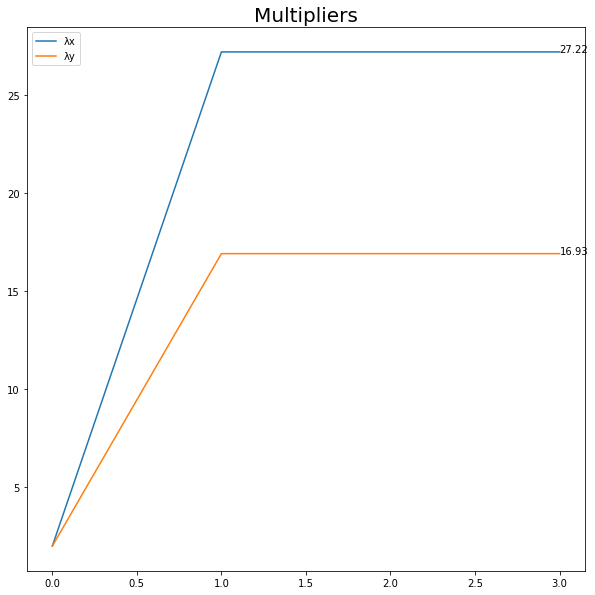

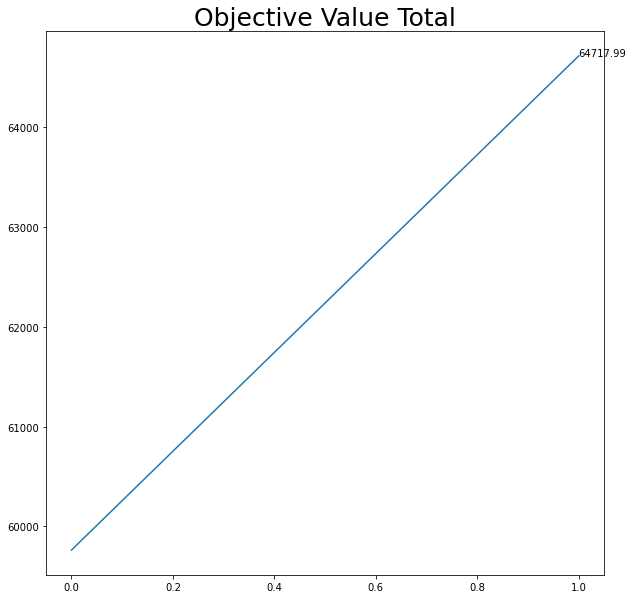

In [37]:
plt.plot(x_lams, label = '\u03BBx'); #suppress matpolotlib output
for i in [iteration-1]:
    plt.text(list(range(0,len(x_lams)))[i],x_lams[i],str(round(x_lams[i],2)))
    
plt.plot(y_lams, label = '\u03BBy');  # ; suppress the matplotlib text

for i in [iteration-1]:
    plt.text(list(range(0,len(y_lams)))[i],y_lams[i],str(round(y_lams[i],2)))

plt.title("Multipliers", fontsize = 20)
plt.legend();
#plt.xticks(range(0,iteration));
plt.show()

total_obj_val = []

for i in list(range(0,len(obj_val_x)-1)):
    total_obj_val.append(obj_val_x[i] + obj_val_y[i+1])

plt.plot(total_obj_val);
for i in [len(total_obj_val)-1]:
    plt.text(i,total_obj_val[i],str(round(total_obj_val[i],2)));
plt.title('Objective Value Total',fontsize = 25)
#plt.xticks(range(0,iteration));
plt.show()